# **Maching Learning and Stocks**
Machine learning can be used to predict whether stock prices will go up or down by leveraging historical data and identifying patterns or relationships between various factors and stock price movements. Here's a simplified explanation of the process:

**Data Collection:** Historical stock market data is collected, including features such as previous price, trading volume, technical indicators, and news sentiment.

**Data Preprocessing:** The collected data is cleaned, transformed, and prepared for training a machine learning model. This may involve handling missing values, scaling features, and splitting the data into training and testing sets.

**Feature Engineering:** Additional features may be derived from the existing data to capture relevant information. For example, moving averages, relative strength index (RSI), or other technical indicators can be calculated to provide more insights into price trends.

**Model Selection:** Different machine learning algorithms suitable for predicting stock price movements, such as decision trees, random forests, support vector machines (SVM), or neural networks, can be considered. The choice depends on the characteristics of the data and the problem at hand.

**Model Training:** The selected machine learning model is trained on the historical data, where it learns the patterns and relationships between the features and the corresponding stock price movements. The model adjusts its internal parameters to minimize the prediction errors.

**Model Evaluation:** The trained model is evaluated using the testing data to assess its predictive performance. Common evaluation metrics include accuracy, precision, recall, F1-score, or area under the receiver operating characteristic (ROC) curve.

**Predictions:** Once the model is trained and evaluated, it can be used to make predictions on new, unseen data. The model takes in the relevant features of the current market conditions and generates predictions on whether the stock price will go up or down.

It's important to note that predicting stock prices accurately is a challenging task due to various factors influencing the stock market, including economic conditions, market sentiment, and unforeseen events. Machine learning models can provide insights and assist in decision-making, but they are not infallible and should be used with caution in real-world trading scenarios.

# **Importing Libraries**
Below we have imported libraries such as pandas to keep our data in dataframes, numpy to be able to convert our data into arrays, and the machine learning models that were necessary for this project.

In [ ]:
import pandas as pd  # Data manipulation and analysis library: https://pandas.pydata.org/
import numpy as np  # Fundamental library for numerical computing: https://numpy.org/
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold  # Model selection and evaluation: https://scikit-learn.org/stable/model_selection.html
from sklearn.linear_model import LinearRegression  # Linear regression modeling: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
from sklearn.tree import DecisionTreeRegressor  # Decision tree-based regression: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
from sklearn.ensemble import RandomForestRegressor, VotingRegressor  # Random forest regression and voting ensemble: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html, https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html
from sklearn.svm import SVR  # Support Vector Regression: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
import matplotlib.pyplot as plt  # Plotting library: https://matplotlib.org/stable/api/pyplot_summary.html
import seaborn as sns  # Statistical data visualization: https://seaborn.pydata.org/
from sklearn.metrics import confusion_matrix  # Confusion matrix: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
import datetime  # Module for working with dates and times: https://docs.python.org/3/library/datetime.html
import yfinance as yf  # Yahoo Finance library for fetching financial data: https://pypi.org/project/yfinance/


# **Gathering the Data**
In this code we gathered the stock data from the past 900 days on Yahoo Finance. Then convert it to a dataframe which the machine learning models can scan through.

[*********************100%***********************]  1 of 1 completed


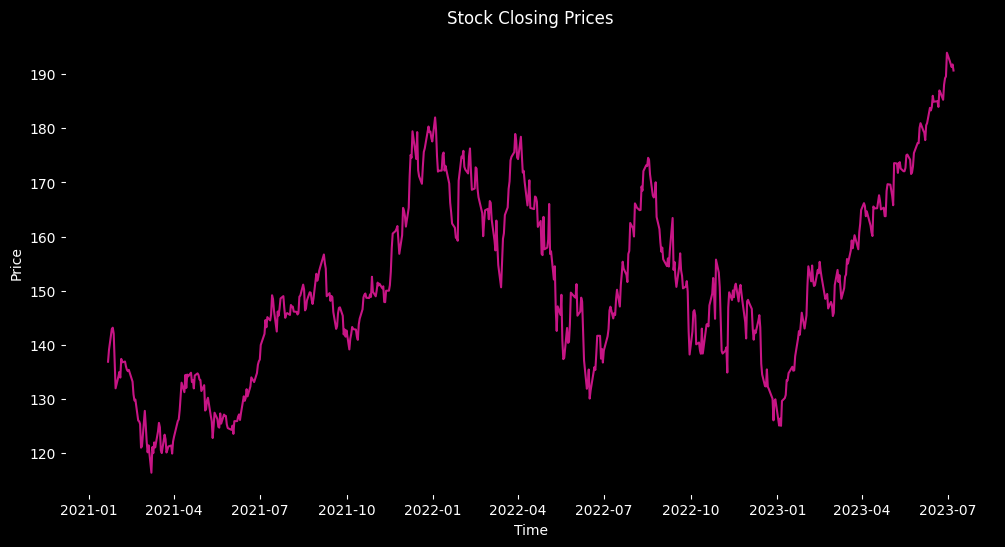

In [ ]:
# Data scraping
# Define the ticker symbol for the stock (e.g., "AAPL" for Apple)
ticker_symbol = "AAPL"

# Set the end date as today
end_date = datetime.datetime.today().strftime('%Y-%m-%d')

# Set the start date as 900 days (approximately 3 years) before today
start_date = (datetime.datetime.today() - datetime.timedelta(days=900)).strftime('%Y-%m-%d')

# Download the stock data for the specified time frame using Yahoo Finance API
data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Save the downloaded data to a CSV file for further use
data.to_csv('AAPL.csv')

# Isolating the close prices from the downloaded data
close_prices = data['Close']

# Set up the figure and axis objects for plotting
fig, ax = plt.subplots()

# Set the background color of the figure and axis to black
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

# Customize the line color and style
line_color = 'mediumvioletred'  # You can change this to any desired color
line_style = '-'  # You can choose different line styles like '--' for dashed line

# Plot the line chart with the close prices
ax.plot(close_prices, color=line_color, linestyle=line_style)

# Set the title and labels for the plot
ax.set_title('Stock Closing Prices', color='white')
ax.set_xlabel('Time', color='white')
ax.set_ylabel('Price', color='white')

# Set the tick colors to white
ax.tick_params(colors='white')

# Set the size of the figure
fig.set_size_inches(12, 6)

# Show the plot
plt.show()


By printing the graph we can visually show the data for which our machine learning model is being trained on.

# **Feature Engineering**
What are features in machine learning? Features are basically sets of data that the machine learning model can use to accurately predict whatever it needs to predict. In this case, we are adding stock market features such as the previous day's closing price, SMA, EMA, RSI, MACD, Bollinger Bands, and Stock Movement. Adding these features gives the model more information to work with.

In [ ]:
# Add features: previous day's closing price, SMA, EMA, RSI, MACD, Bollinger Bands

# Add a new column 'prevClose' with the previous day's closing price
data['prevClose'] = data['Close'].shift(1)

# Calculate Simple Moving Average (SMA) for different window sizes
window_sizes = [7, 30]
for window_size in window_sizes:
    column_name = f'SMA_{window_size}'
    data[column_name] = data['prevClose'].rolling(window=window_size).mean()

# Calculate Exponential Moving Average (EMA) for different window sizes
for window_size in window_sizes:
    column_name = f'EMA_{window_size}'
    data[column_name] = data['prevClose'].ewm(span=window_size, adjust=False).mean()

# Calculate Relative Strength Index (RSI)
delta = data['prevClose'].diff()
gain = delta.mask(delta < 0, 0)
loss = -delta.mask(delta > 0, 0)
average_gain = gain.rolling(window=14).mean()
average_loss = loss.rolling(window=14).mean()
rs = average_gain / average_loss
rsi = 100 - (100 / (1 + rs))
data['RSI'] = rsi

# Calculate Moving Average Convergence Divergence (MACD)
ema_12 = data['prevClose'].ewm(span=12, adjust=False).mean()
ema_26 = data['prevClose'].ewm(span=26, adjust=False).mean()
macd = ema_12 - ema_26
signal_line = macd.ewm(span=9, adjust=False).mean()
data['MACD'] = macd
data['Signal Line'] = signal_line

# Calculate Bollinger Bands
rolling_mean = data['prevClose'].rolling(window=20).mean()
rolling_std = data['prevClose'].rolling(window=20).std()
upper_band = rolling_mean + (2 * rolling_std)
lower_band = rolling_mean - (2 * rolling_std)
data['Upper Band'] = upper_band
data['Lower Band'] = lower_band

# Create a new column 'Price_Difference' with the price differences
data['Price_Difference'] = data['Close'].diff()

# Create a new column 'Stock_Movement' indicating the direction of stock movement (0 for up, 1 for down)
data['Stock_Movement'] = np.where(data['Price_Difference'] > 0, 1, 0)

# Display the first five rows of the data
data.head()


,Open,High,Low,Close,Adj Close,Volume,prevClose,SMA_7,SMA_30,EMA_7,EMA_30,RSI,MACD,Signal Line,Upper Band,Lower Band,Price_Difference,Stock_Movement
Date,,,,,,,,,,,,,,,,,,
2021-01-21,133.800003,139.669998,133.589996,136.869995,134.853745,120150900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2021-01-22,136.279999,139.850006,135.020004,139.070007,137.021362,114459400,136.869995,NaN,NaN,136.869995,136.869995,NaN,0.000000,0.000000,NaN,NaN,2.200012,1
2021-01-25,143.070007,145.089996,136.539993,142.919998,140.814621,157611700,139.070007,NaN,NaN,137.419998,137.011931,NaN,0.175500,0.035100,NaN,NaN,3.849991,1
2021-01-26,143.600006,144.300003,141.369995,143.160004,141.051071,98390600,142.919998,NaN,NaN,138.794998,137.393097,NaN,0.618121,0.151704,NaN,NaN,0.240005,1
2021-01-27,143.429993,144.300003,140.410004,142.059998,139.967285,140843800,143.160004,NaN,NaN,139.886250,137.765155,NaN,0.977006,0.316764,NaN,NaN,-1.100006,0


# **Splitting the Data**
What is the target variable? The target variable in machine learning is what we want to predict, like whether a stock price will go up or down. The model learns from data about stocks, including various features like historical prices, trading volume, and news sentiment, to make predictions about future stock movements. When we split the data, we are just separating the features of the stocks from the target variable.

In [ ]:
# Splitting the data into features (X) and target variable (y)

# Select the features from the dataset, excluding the last column
X = data.iloc[30:, :-1]

# Select the target variable from the dataset, which is the last column
y = data.iloc[30:,-1]


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Initializing the Models**
Initializing machine learning models means setting up their starting values. It's like giving a robot some basic knowledge before it learns. The model adjusts its settings to make predictions. By initializing the model, we give it a starting point to improve from as it learns from data. In the code below we are initializing each individual model, then initilializing the ensemble model.
An ensemble model is like asking a group of friends for their opinions on something. Each friend gives their own prediction, and then we take the average or the most common answer to make a final decision. This helps us get a more accurate result by considering different viewpoints.

In [ ]:
# Initialize stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)

In [ ]:
# Initializing each regression model
linear_regression = LinearRegression()
decision_tree_regressor = DecisionTreeRegressor()
random_forest_regressor = RandomForestRegressor()
support_vector_regressor = SVR()

In [ ]:
# Initializing the voting ensemble model with each regression model
voting_regressor = VotingRegressor(
    estimators=[
        ('linear', linear_regression),
        ('decision_tree', decision_tree_regressor),
        ('random_forest', random_forest_regressor),
        ('svm', support_vector_regressor)
    ]
)

# **Training the Models on the Data**

Training a machine learning model on data is like teaching it using examples. We show the model lots of examples with labels, like pictures of fruits with their names. The model learns from these examples and figures out the patterns between the features (like size or color) and the labels. This helps the model make accurate predictions when it sees new examples it hasn't seen before.

In [ ]:
# Fit the voting regressor on the training data
voting_regressor.fit(X_train, y_train)

# Predict on the testing data
y_pred = voting_regressor.predict(X_test)

threshold = .5  # Adjust the threshold according to your needs
y_pred_binary = [1 if pred > threshold else 0 for pred in y_pred]

# Create the true labels (y_true)
y_true = y_test  # Assuming your testing data already contains the true labels

# **Results of the Predictions**
In the code below we evaluate how the models predicted in several different manners. The first was by comparing the predictions to the actual values through a confusion matrix. A confusion matrix is a simple way to disply the predicted and actual values.

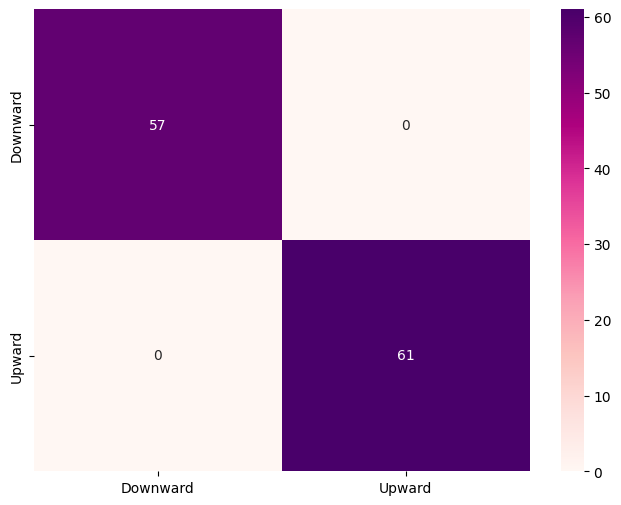

In [ ]:
# Create the confusion matrix
cm = confusion_matrix(y_true, y_test)

# Create a DataFrame from the confusion matrix
cm_df = pd.DataFrame(cm, index=['Downward', 'Upward'], columns=['Downward', 'Upward'])

# Set the style with a dark background

# Create a black-colored heatmap with white text
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm_df, annot=True, cmap='RdPu')

# Showing the test data
plt.show()

In [ ]:
# Evaluate the Accuracy of the Model
cross_val_scores = cross_val_score(voting_regressor, X, y, cv=skf)

# Print the cross-validation scores
print("Cross-validation Scores:", cross_val_scores)
print("Mean Score:", cross_val_scores.mean())

Cross-validation Scores: [0.84338281 0.82915863 0.84287453 0.84972492 0.84112752 0.84322088
 0.8435572  0.83660913]
Mean Score: 0.8412069503822972


In [ ]:
# Print the prediction for tomorrows stock price
yesterday_close = data['prevClose'].iloc[-1]

if np.all(y_pred < yesterday_close):
  print('The price is going to go down.')
else:
  print('The price is going up!')

The price is going to go down.
